In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scipy
import statsmodels.formula.api as smf
import random
from scipy.stats import iqr
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [67]:
df_salary = pd.read_csv('salary.csv')
df_salary[df_salary.salary.isnull()]

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
208,NaN,0,21,10,0.93,1,0,3,1,4,1


In [68]:
#Drop Nan values is salary column
df_salary = df_salary.dropna()

#Rename as per metadata
df_salary =df_salary.rename(columns ={'male':'gender', 'experior':'Experience', 'yearsabs':'years_absent'})
df_salary.gender = ['male' if i == 1 else 'female' for i in df_salary.gender]
df_salary.position = ['Jnr_employee' if i == 1 else 'Manager' if  i == 2 else 'Executive' for i in df_salary.position]
df_salary.Field = ['Engineering' if i == 1 else 'Finance' if i == 2 else 'Human Resource' for i in df_salary.Field]    
df_salary = pd.DataFrame(df_salary)
df_salary

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,gender,Field,years_absent
0,53000.0,0,0,0,1.17,1,0,Jnr_employee,male,Human Resource,0
1,58000.0,1,0,0,1.24,1,0,Jnr_employee,male,Finance,0
2,45500.0,0,0,0,1.21,1,0,Jnr_employee,male,Human Resource,2
3,35782.0,0,2,1,0.99,1,0,Jnr_employee,male,Human Resource,1
4,34731.0,0,2,2,0.91,1,0,Jnr_employee,male,Human Resource,1
...,...,...,...,...,...,...,...,...,...,...,...
509,45906.0,6,17,11,0.92,1,0,Manager,female,Finance,70
510,60402.0,6,19,7,0.86,1,0,Executive,female,Engineering,72
511,53187.0,19,7,6,0.78,1,0,Executive,female,Human Resource,76
512,56542.0,8,20,10,0.78,1,0,Executive,female,Finance,78


### 1.1 Split your data into a training and test set.

In [69]:
#Splitting the data into the train and test set"
split = len(df_salary)*0.8
print("80% of the data set must contain ",round(split), 'rows')
df_sample = df_salary.loc[:,['salary','yearsworked','position','gender','Field','yearsrank']]
df_train =  df_sample.loc[:split,:]
df_test = df_sample.loc[split:,:]
df_train

80% of the data set must contain  410 rows


,salary,yearsworked,position,gender,Field,yearsrank
0,53000.0,0,Jnr_employee,male,Human Resource,0
1,58000.0,0,Jnr_employee,male,Finance,0
2,45500.0,0,Jnr_employee,male,Human Resource,0
3,35782.0,2,Jnr_employee,male,Human Resource,1
4,34731.0,2,Jnr_employee,male,Human Resource,2
...,...,...,...,...,...,...
406,33680.0,3,Jnr_employee,female,Human Resource,3
407,35000.0,0,Jnr_employee,female,Human Resource,0
408,36833.0,3,Jnr_employee,female,Human Resource,3
409,31000.0,0,Jnr_employee,female,Human Resource,0


### About the DataFrame: df_Salary
1. There are **514 entries/observation** in this dataset meaning that **514 employees'** data is recorded.
2. There is **one null value** in *Salary column*
3. The *gender* column contains **two unique values of type object: male or female**
4. The *Experience,years worked, years rank* columns contains **continuous values of type int*
5. *Market* column contains **continuous value of type float**
6. The *position* and *field* column contains **three unique values of type object(pandas string): {Jnr Employee, Executive or Manager} and {Human Resource, Finance or Engineering} respectively** 
   

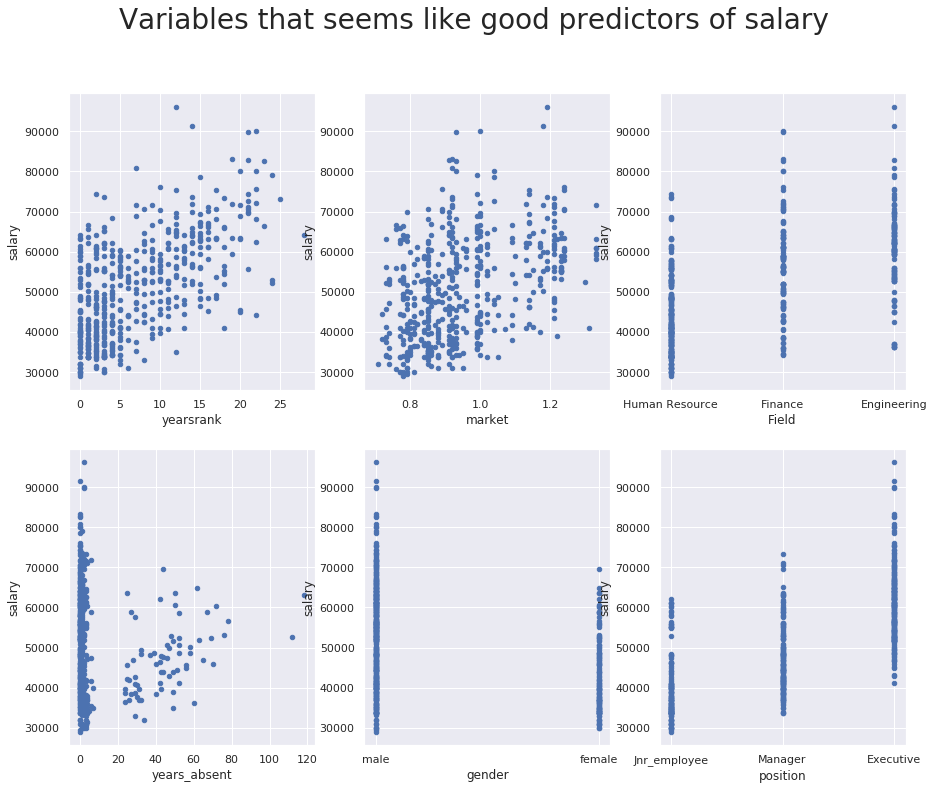

In [81]:
# Reducing the level of the axis logger to error:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

fig, axs = plt.subplots(2, 3,)
fig.suptitle('Variables that seems like good predictors of salary', fontsize=28)
df_salary.plot(kind='scatter', x='yearsrank', y='salary', ax=axs[0,0],figsize=(15, 12))
df_salary.plot(kind='scatter', x='market', y='salary', ax=axs[0,1])   
df_salary.plot(kind='scatter', x='Field', y='salary', ax=axs[0,2])
df_salary.plot(kind='scatter', x='years_absent', y='salary', ax=axs[1,0])
df_salary.plot(kind='scatter', x='gender', y='salary', ax=axs[1,1])
df_salary.plot(kind='scatter', x='position', y='salary', ax=axs[1,2])
plt.show()

### Examine the training data for Extreme Values

In [34]:
#Check for outliers:Train
q75_train, q25_train = np.percentile(df_train['salary'], [75 ,25])
iqr_train = q75_train - q25_train
lower_bound = q25_train - iqr_train*1.5
upper_bound = q75_train + iqr_train*1.5

q75_test, q25_test = np.percentile(df_test['salary'], [75 ,25])
iqr_test = q75_test - q25_test
test_lower_bound = q25_test - iqr_test*1.5
test_upper_bound = q75_test + iqr_test*1.5
print('Q1 for training set: $',q25_train)
print('Q3 for training set: $',q75_train)
print('Lower outlier boundry: $',lower_bound )
print('Upper outlier boundry: $',upper_bound )

print('Q1 for testing set: $',q25_test)
print('Q3 for testing set: $',q75_test)
print('Lower outlier boundry: $',test_lower_bound )
print('Upper outlier boundry: $',test_upper_bound )

Q1 for training set: $ 41109.75
Q3 for training set: $ 61722.25
Lower outlier boundry: $ 10191.0
Upper outlier boundry: $ 92641.0
Q1 for testing set: $ 37487.0
Q3 for testing set: $ 50144.0
Lower outlier boundry: $ 18501.5
Upper outlier boundry: $ 69129.5


In [35]:
df_train['Is_it_an_extreme'] = ['Yes' if i < lower_bound else 'Yes' if i > upper_bound else "No" for i in df_train.salary]
df_outliers = df_train[df_train.Is_it_an_extreme == 'Yes']
df_outliers = df_outliers
df_outliers

,salary,yearsworked,position,gender,Field,yearsrank,Is_it_an_extreme
index,,,,,,,
377,96156.0,12,Executive,female,Human Resource,12,Yes


In [36]:
# cond = df_train['salary'].isin(df_outliers['salary'])
# df_train=df_train.drop(df_outliers[cond].index, inplace = True)
# # df_train


In [37]:
df_test['Is_it_an_extreme'] = ['Yes' if i < test_lower_bound else 'Yes' if i > test_upper_bound else "No" for i in df_test.salary]
df_test_outliers = df_test[df_test.Is_it_an_extreme == 'Yes']
df_test_outliers

,salary,yearsworked,position,gender,Field,yearsrank,Is_it_an_extreme
index,,,,,,,
481,69654.33594,17,Executive,female,Human Resource,12,Yes


In [38]:
# cond = df_test['salary'].isin(df_test_outliers['salary'])
# df_test=df_test.drop(df_test_outliers[cond].index, inplace = True)
# df_test

The train and test sets have 1 outlier each and thus they were dropped. 

#### Below is a summary statistics showing the statistics for every column in the data frame




In [39]:
df_salary.describe()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,years_absent
count,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,50863.220098,2.931774,12.836257,7.046784,0.948558,0.964912,0.044834,6.994152
std,12685.132358,4.794327,9.447040,6.419708,0.149524,0.184181,0.207142,16.887552
min,29000.000000,0.000000,0.000000,0.000000,0.710000,0.000000,0.000000,0.000000
25%,40000.000000,0.000000,4.000000,2.000000,0.840000,1.000000,0.000000,0.000000
50%,50096.000000,1.000000,12.000000,5.000000,0.920000,1.000000,0.000000,1.000000
75%,60345.000000,4.000000,22.000000,12.000000,1.020000,1.000000,0.000000,2.000000
max,96156.000000,25.000000,41.000000,28.000000,1.330000,1.000000,1.000000,118.000000


### 1.3 Histograms to show the distribution between salary and other variables 

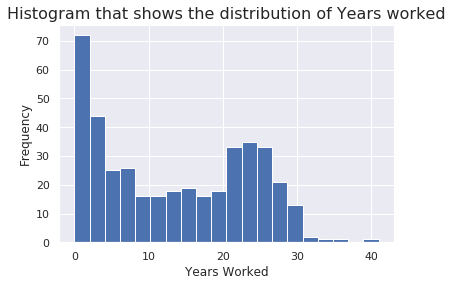

In [40]:
sns.set()

plt.hist(df_train.yearsworked, bins=20)

plt.title('Histogram that shows the distribution of Years worked', fontsize=16)
plt.xlabel('Years Worked')
plt.ylabel('Frequency')
plt.show()

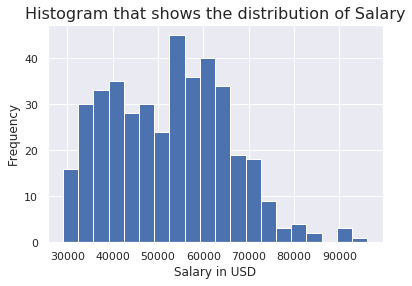

In [41]:
sns.set()

plt.hist(df_train.salary, bins=20)

plt.title('Histogram that shows the distribution of Salary', fontsize=16)
plt.xlabel('Salary in USD')
plt.ylabel('Frequency')
plt.show()

### 1.4 Scatterplot showing the relationship between Years Worked and Salary

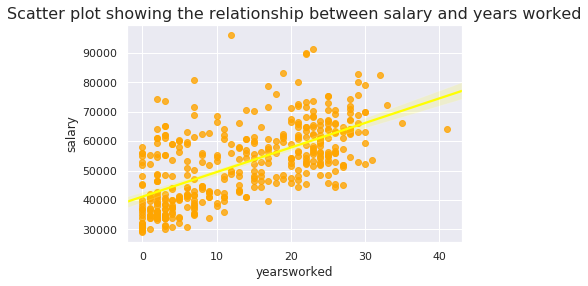

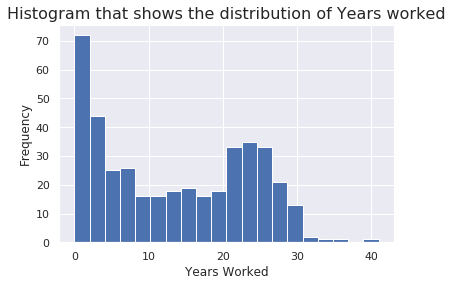

In [42]:
sns.set()
sns.regplot(x='yearsworked', y='salary', data=df_train, scatter_kws={"color": "orange"}, line_kws={"color": "Yellow"})
plt.title('Scatter plot showing the relationship between salary and years worked', fontsize=16)
plt.show()

plt.hist(df_train.yearsworked, bins=20)

plt.title('Histogram that shows the distribution of Years worked', fontsize=16)
plt.xlabel('Years Worked')
plt.ylabel('Frequency')
plt.show()

### 2.  Using the statsmodels package and the training data, run a simple linear regression for Salary

In [43]:
import statsmodels.formula.api as smf
# create a fitted model in one line
model = smf.ols(formula='salary ~ yearsworked', data=df_train).fit()
# print the coefficients
model.params

Intercept      41099.130188
yearsworked      836.035620
dtype: float64

In [44]:
print('A 1 year increase in a year worked will result in salary increase equal to the slope of the model')

A 1 year increase in a year worked will result in salary increase equal to the slope of the model


In [45]:
df_train['salary']=df_train.fillna(0)
coeffs = scipy.pearsonr(df_train.salary,df_train.yearsworked)
coeffs


(0.6333963663825476, 2.2904710244135097e-47)

**R > 0.6** Means there is a positive correlation between the variables

**R > 0.6** A moderate positive relationship

The correlation coefficient suggest that the data follows a linear relationship and it is normally distributed. The correlation coefficient is closer to 1 than it is to 0 which shows a moderate positive relationship between the two variables.

The **p_value** is too small and indicates strong evidence against the null hypothesis that the relationship between the variables is statistically significant since it is smaller than the *threshold* of the *P_value* of **p= 0.05**.

In [46]:
#R^2 

coeffs[0]**2
print(round(coeffs[0],2)**2, ' Shows that ',(round(coeffs[0],2)**2)*100,'% of the data fits the model or that amount of employees’ salaries is accounted for by the number of years they have worked. Also, R_squared is known as a coefficient of determination' )

0.39690000000000003  Shows that  39.690000000000005 % of the data fits the model or that amount of employees’ salaries is accounted for by the number of years they have worked. Also, R_squared is known as a coefficient of determination


### 3. Meaning of a confidence interval

In [47]:
# print the confidence intervals for the model coefficients
model.conf_int()

,0,1
Intercept,39432.997692,42765.262684
yearsworked,736.632134,935.439106


**From this, we can deduce that the true coefficient value of the salary population, will between these intervals. Simply put, if thousands of samples from a population was formed, this condition will hold 95% of the time.**

**This is a common shorthand for the idea that the calculations “work” 95% of the time. Only 5 % will this be not the case**

### 5. Calculate the expected salary for someone with 12 and 80 years’ work experience.

In [48]:
#Estimating a person that worked for 12 years

x = pd.DataFrame({'yearsworked':[12]})
model.predict(x)

0    51131.557629
dtype: float64

In [49]:
y = pd.DataFrame({'yearsworked':[80]})
model.predict(y)

0    107981.979797
dtype: float64

In [50]:
f'Maximum years worked(in numbers) %s' %df_salary.yearsworked.max()

'Maximum years worked(in numbers) 41'

As per the model, it predicts that person who has worked for 12 years will earn, on average, the salary above. This value is interesting because the salary is not far off from the mean. This is because the mean for years worked is just over 12 years, meaning, on average, an employee at this company is to be expected to have worked for 12 years.

Yes there also seem to be a problem, the model predicts the salary level that is bigger than the maximum salary in the data set. The model assumes that people can work indefinetly and hence the prediction, in reality, rarely does a person spend 80 years in the workforce. Even in the data set the person who have worked longer than the rest only worked for 41 years.

### 7. What other employee characteristics might influence their salary

In [51]:
df_salary.corr()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,years_absent
salary,1.000000,0.119989,0.623589,0.610706,0.407214,0.044554,0.167137,-0.069630
exprior,0.119989,1.000000,-0.245788,-0.065893,-0.035202,-0.049165,0.264655,0.132022
yearsworked,0.623589,-0.245788,1.000000,0.813456,-0.070740,0.028122,-0.040157,0.056113
yearsrank,0.610706,-0.065893,0.813456,1.000000,-0.026869,0.006347,0.007232,0.035962
market,0.407214,-0.035202,-0.070740,-0.026869,1.000000,0.036456,0.021641,-0.167177
degree,0.044554,-0.049165,0.028122,0.006347,0.036456,1.000000,-0.214654,0.029447
otherqual,0.167137,0.264655,-0.040157,0.007232,0.021641,-0.214654,1.000000,-0.017792
years_absent,-0.069630,0.132022,0.056113,0.035962,-0.167177,0.029447,-0.017792,1.000000


 This is how others are correlated with salary:

1. **Rank on salary**
Moderate positive correlation
2. **Experience**
Very Weak positive correlation
3. **Market**
Weak Positive correlation
4. **Degree**
5. Very weak positive correlation
6. **Other Qualification**
7. Ver weak positive correlation
8. **Years absent**
Negative correlation

In [52]:
print('Below is the OLS regressionn summary:')
model.summary()


Below is the OLS regressionn summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     273.4
Date:                Tue, 17 Mar 2020   Prob (F-statistic):           2.29e-47
Time:                        13:04:41   Log-Likelihood:                -4360.2
No. Observations:                 410   AIC:                             8724.
Df Residuals:                     408   BIC:                             8733.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     4.11e+04    847.562     48.491      0.000    3.94e+04    4.28e+04
yearsworked   836.0356     50.567     16.533      0.000     736.632     935.439
==============================================================================
Omnibus:                       58.220   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.803
Skew:                           0.965   Prob(JB):                     1.72e-18
Kurtosis:                       4.031   Cond. No.                         28.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 8. How does your model compare when running it on the test set - what is the difference in the Root Mean Square Error (RMSE) between the training and test sets? Is there any evidence of overfitting?


In [53]:
df_train_comp = model.predict(df_train)
df_train_comp = pd.DataFrame(df_train_comp)
df_train_comp.rename(columns={0:'Predicted','salary':'Actual'})
df_train_comp['salary'] = df_train['salary']

In [54]:
df_train_comp = df_train_comp.loc[:,['salary',0]]
df_train_comp.rename(columns={0:'Predicted'})
y_actual = df_train_comp.salary
y_predicted = df_train_comp[0]
from sklearn.metrics import mean_squared_error
from math import sqrt
rms_train = sqrt(mean_squared_error(y_actual,y_predicted))


In [55]:
df_test_comp = model.predict(df_test)
df_test_comp = pd.DataFrame(df_test_comp)
df_test_comp.rename(columns={0:'Predicted'})
df_test_comp['salary'] = df_test['salary']
df_test_comp = df_test_comp.dropna()

In [56]:
df_test_comp = df_test_comp.loc[:,['salary',0]]
df_test_comp.rename(columns={0:'Predicted', 'salary':'Actual'})
df_test.salary.fillna(df_test.salary.mean())
y_actual1 = df_test_comp.salary
y_predicted1 = df_test_comp[0]
rms_test = sqrt(mean_squared_error(y_actual1,y_predicted1))
rms_train = sqrt(mean_squared_error(y_actual,y_predicted))


In [57]:
print('The RMSE of the train data is: ',rms_train)
print('And The RMSE of the test data is: ',rms_test,'which shows little to no signs of underfitting')

The RMSE of the train data is:  10054.850543984176
And The RMSE of the test data is:  9542.511107005375 which shows little to no signs of underfitting


In [58]:
df_train.describe()

,yearsworked,yearsrank
count,410.000000,410.000000
mean,13.565854,7.509756
std,9.856268,6.728486
min,0.000000,0.000000
25%,4.000000,2.000000
50%,13.000000,5.000000
75%,23.000000,13.000000
max,41.000000,28.000000
